In [1]:
import tarfile

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sncosmo
import pandas as pd
import math
import glob 
from astropy.table import Table
import os.path
#import sfdmap
import scipy
from scipy.interpolate import CubicSpline
from scipy import interpolate
import iminuit
import extinction
from extinction import ccm89, apply

In [22]:
g = [17.50730179, 17.57542295, 17.59185904, 17.60377225, 17.71480652, 17.63503376,
 17.64655381, 17.71615066, 17.70052693, 17.70152612, 17.72268904, 17.76079853,
 17.744379,   17.7649664,  17.8331249,  17.77542093, 17.78544313, 17.81764184,
 17.82327427, 17.84527891,17.89717336, 18.02365386, 18.06881873, 18.03841263,
 18.02156726, 18.04074873, 18.08447925, 18.1173411,  18.06331561, 18.10175802,
 18.12694771, 18.09705869, 18.28334109, 18.13586159, 18.17938367, 18.1444583,
 18.24500877, 18.2407385,  18.24669848, 18.29750574, 18.23986959, 18.26000857,
 18.188986,   18.30242164, 18.29346369, 18.29582119, 18.30368972, 18.34078603,
 18.37773057, 18.25195438, 18.47123305, 18.36951107, 18.37795652, 18.40710137]
r = [17.19855227, 17.2211747,  17.25319724, 17.12604214, 17.25591341, 17.26962013,
 17.29341936, 17.26941851, 17.26986421, 17.28092894, 17.26329519, 17.27667877,
 17.29404125, 17.34240609, 17.30034087, 17.32842881, 17.34412795, 17.37142426,
 17.40645152, 17.44497983, 17.42425303, 17.45376136, 17.43166704, 17.46820764,
 17.469188,   17.44309294, 17.39849734, 17.47383426, 17.45509855, 17.49140864,
 17.48483772, 17.53158365, 17.56327171, 17.49929765, 17.61514946, 17.55572394,
 17.56323256, 17.55005789, 17.5860888,  17.60561246, 17.60051245, 17.65230148,
 17.60353429, 17.60725195, 17.62496857, 17.68258735, 17.65102715, 17.64013488,
 17.6851517,  17.72068709]
i = [17.45661163, 17.42751201, 17.56383286]

print(len(g))
print(len(r))
print(len(i))

54
50
3


In [7]:
# create model spectrum at same redshift as observed SN
wave = np.linspace(3000, 10000, 400) # match size of flux array if reading in csv

# get type IIP template from sncosmo
model = sncosmo.Model(source='nugent-sn2p')
model.set(z=0.01815) # set template redshift to redshift of the observed SN

# get flux at day 50
flux = model.flux([25], wave)[0]
fluxerr= flux*0.01 # arbitrary uncertainty 

spectrum = sncosmo.Spectrum(wave, flux, fluxerr, time=25) #creates spectrum with the flux and wavelength we observed 

In [8]:
# input observed mags:
## define filters:
filter_names = ['sdssg', 'sdssr', 'sdssi']
## define obs mags:
obs_mags = np.array([g[0], r[0], i[0]])

# pd table 
mags_table = pd.DataFrame(data=[obs_mags], columns=filter_names) 
print(mags_table)

       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612


In [9]:
# define filters using sncosmo
g_band = sncosmo.get_bandpass('sdssg')
r_band = sncosmo.get_bandpass('sdssr')
i_band = sncosmo.get_bandpass('sdssi')

filters = [g_band, r_band, i_band]

In [10]:
# find the edges and center wavelengths of each band. These will become the x-values of the knots
# I found the edges by finding the first non-zero point and the last non-zero point  
def find_start(band, wave):
    for index, num in enumerate(band(wave)):
        if num > 0:
            return index
            break

def find_end(band, wave):
    for index in range(len(band(wave)) - 1, -1, -1):
        if band(wave)[index] != 0:
            last_non_zero_index = index
            break
    return last_non_zero_index


def find_middle(band, wave):
    start = find_start(band, wave)
    end = find_end(band, wave)
    
    new_band = band(wave)[start:end]
    
    length = len(new_band)
    index = length // 2
    index = start + index
    return index

In [11]:
# remove overlapping points within the find_knots_xs function
def remove_overlap(knots_xvals):
    averages = []
    
    for i in range(2, len(knots_xvals) - 1, 3):
        average = (knots_xvals[i] + knots_xvals[i + 1]) / 2
        averages.append(average)
        
        array_deleted_vals = np.delete(knots_xvals, np.s_[2:- 1:3])
        array_deleted_vals = np.delete(array_deleted_vals, np.s_[2:-1:2])
        new_array = np.append(array_deleted_vals, averages)
    
    return new_array
    
    
def find_knots_xs(filters):
    knots_xvals = np.array([])
    for i in filters:
        # find start, middle, and end
        start_index = find_start(i, wave)
        start = wave[start_index]
        middle_index = find_middle(i, wave)
        middle = wave[middle_index]
        end_index = find_end(i, wave)
        end = wave[end_index]
        

        knots_xvals = np.append(knots_xvals, [start, middle, end])
        
        knots_xvals = np.sort(knots_xvals)
    #print(knots_xvals)
    
    # remove overlapping points    
    knots_xvals_new = remove_overlap(knots_xvals)
    knots_xvals_new = np.sort(knots_xvals_new)
    #print('removed overlap', knots_xvals_new)
    
        
    # add more knots    
    averages = []
    for i in range(len(knots_xvals_new) - 1):
        avg = (knots_xvals_new[i] + knots_xvals_new[i+1]) / 2
        averages.append(avg)
        
    knots_xvals_new = np.append(knots_xvals_new, averages)
    knots_xvals_new = np.sort(knots_xvals_new)
        
    return knots_xvals_new

In [12]:
# This function finds which filter is in the middle of the other filters (made to generalize code for any number of filters)
def find_mid_filter(filters):    
    
    
    middles = []
    for i in filters:
        filter_middle_index = find_middle(i, wave)
        filter_middle = wave[filter_middle_index]
        middles.append(filter_middle)
    
    def find_middle_val(lst):
        average = sum(lst) / len(lst)
        closest_value = lst[0]
        closest_difference = abs(lst[0] - average)

        for value in lst:
            difference = abs(value - average)
            if difference < closest_difference:
                closest_value = value
                closest_difference = difference

        return closest_value
    
    middle_filter_middle_val = find_middle_val(middles)
    
    for i in middles:
        if i == middle_filter_middle_val:
            middle_filter_index = middles.index(middle_filter_middle_val) # returns the index of the value of the middle filter in the list of all middle values
            return filters[middle_filter_index]

In [13]:
# normalize template spectrum to mag of middle band of observed data 
# this give us the template mags that we will mangle to match the observed magnitudes

def normalize_template(filters, filter_names, mags_table):
    middle_filter = find_mid_filter(filters)
    for band in filter_names:
        if band == middle_filter.name:
            middle_mag = round(mags_table[band][0], 4)
            
            
            
    
    ab = sncosmo.get_magsystem('ab')
    mags = np.array([])
    for i in filters:
        constant = (ab.band_mag_to_flux(middle_mag, i))/(spectrum.bandflux(i)) #ratio of norm value / model value
        spectr = sncosmo.Spectrum(wave, flux*constant, fluxerr*constant) # make new spectrum with flux normalized to r-band. bascially input band is now r-band in this spectrum
        mag = spectr.bandmag(middle_filter, magsys='ab') #returns mag of spectrum in r-band, so r will come out the same, g and i will be normalized to r
        mags = np.append(mags, mag)
        new_flux = spectr.flux
    return mags, new_flux

template_mags, new_flux = normalize_template(filters, filter_names, mags_table)

In [14]:
# a table that contains the observed mags and the template mags
mags_table.loc[1] = template_mags

print('0 = observed mags, 1 = template (model) mags')
print(mags_table)

0 = observed mags, 1 = template (model) mags
       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612
1  16.864599  17.198600  17.114106


In [15]:
# find the y values of the knots -- since we normalized the spectrum to the r-band, the center of the r-band should be 1
# since the bands have some overlap I'm finding one value for the edge between g and r band as well as the edge between r and i band


def average_and_insert(arr):
    if len(arr) < 2:
        return arr  # Return the original array for arrays with less than 2 elements

    new_array = [arr[0]]  # Initialize the new array with the first element of the original array
    for i in range(len(arr) - 1):
        average = (arr[i] + arr[i + 1]) / 2.0
        new_array.append(average)
        new_array.append(arr[i + 1])  # Append the next element from the original array

    return new_array


def find_knots_ys(obs_mags, template_mags):
    # find the knots that correlate to the middle of the band
    y_knots_middles = 10**(-0.4*(obs_mags-template_mags))
    #print('middles:', y_knots_middles)
    # find the knots that correlate to the highs and lows in between the middles
    y_knots_highslows = np.array([])
    y_knots_highslows = average_and_insert(y_knots_middles)
    #lowest middle = lowest low and highest middle = highest high
    y_knots_highslows = np.append(y_knots_middles[0], np.append(y_knots_highslows, y_knots_middles[-1]))
    # add a knot in between every knot
    y_knots_more = average_and_insert(y_knots_highslows)
    
    return  y_knots_more

print(find_knots_ys(obs_mags, template_mags))

[0.5532468915950203, 0.5532468915950203, 0.5532468915950203, 0.664946159176488, 0.7766454267579557, 0.8883446943394233, 1.000043961920891, 0.9323963797812531, 0.8647487976416153, 0.7971012155019774, 0.7294536333623397, 0.7294536333623397, 0.7294536333623397]


In [16]:
def find_corrected_mag(knots_xs, knots_ys, filters, flux_input):

    # interpolates curve between knots
    s = interpolate.InterpolatedUnivariateSpline(knots_xs, knots_ys)
    xfit = wave
    yfit = s(xfit)

    # makes it so curve is flat before first knot and after last knot
    
    shortest_filter = filters[0]
    shortest_filter_startindex = find_start(shortest_filter, wave)
    
    longest_filter = filters[-1]
    longest_filter_endindex = find_end(longest_filter, wave)
    
    yfit[:shortest_filter_startindex] = [knots_ys[0]] * shortest_filter_startindex
    yfit[longest_filter_endindex+1:] = [knots_ys[-1]] * (len(yfit) - longest_filter_endindex - 1)
    
    # multiply flux 
    flux_output = flux_input*yfit

    spectrum_new = sncosmo.Spectrum(wave, flux_output) 
    
    return spectrum_new, flux_output, yfit

In [17]:
def normalize_spectrum(spectrum_in, bands, mags_table):
    middle = mags_table[middle_filter.name]
    templ_mid = middle[1]
    obs_mid = middle[0]

    flux_in = spectrum_in.flux 
    flux_out = flux_in*10**((templ_mid-obs_mid)/2.5)
    spectrum_out = sncosmo.Spectrum(wave, flux_out)
    return spectrum_out

In [18]:
# define x knots, they will stay the same
knots_xs = find_knots_xs(filters)
# define middle filter
middle_filter = find_mid_filter(filters)

In [19]:
## now put all the functions together to 'mangle' the spectrum
## need an initial function that directly inputs the observed colors, rather than pulling them from the model spectrum
## a plot is included to visualized how the spectrum is 'mangled'
def mangle_1sttime(flux, template_mags):
    
     
    # compute y-values of knots based on the original template mags 
    knots_ys = find_knots_ys(obs_mags, template_mags)
    
    # compute splines and multiply new spectrum and flux by splines
    spectrum_new, flux_new, yfit = find_corrected_mag(knots_xs, knots_ys, filters, new_flux)

    # plot   
    plt.figure()

    plt.plot(wave, flux, color='black', label='spectrum normalized to middle bandpass')


    plt.plot(wave, flux_new, color='g', label='spectrum multiplied by interpolation values')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("wavelength")
    plt.ylabel("flux")
    plt.show()
    
    plt.figure()
    plt.plot(knots_xs, knots_ys, 'ro', label='knots')
    plt.plot(wave, yfit, color='b', label='knot interpolation')
    plt.show()
    
    # check the new magnitudes in each band -- should be closer to obs mags
    for i in range(len(filters)):
        print(filters[i].name, spectrum_new.bandmag('{}'.format(filters[i].name), magsys='ab'))
    
    return spectrum_new

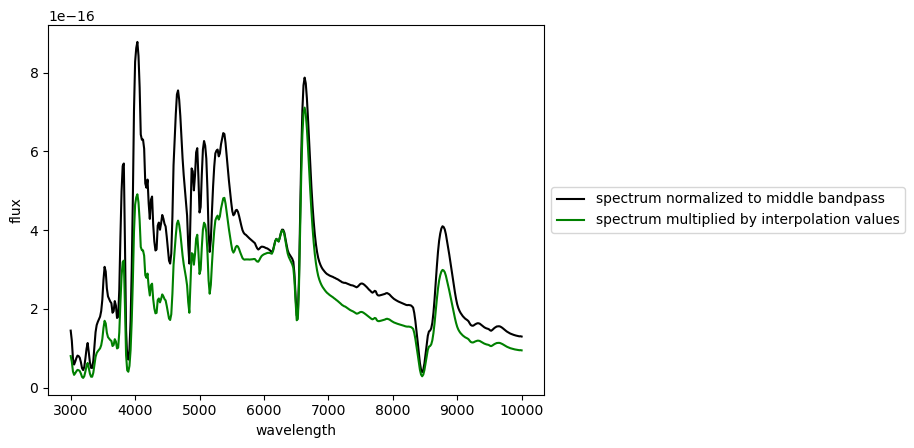

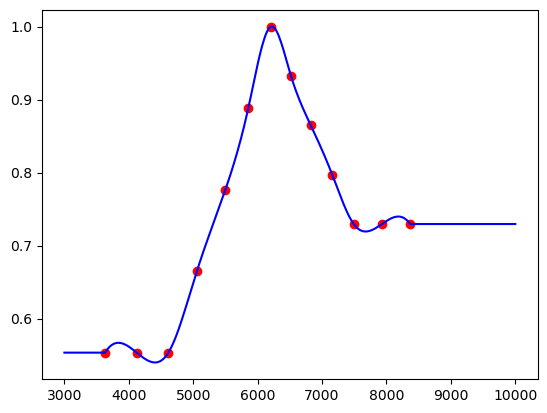

sdssg 17.979889129975582
sdssr 17.203849023078913
sdssi 17.494495302492446


In [20]:
spectrum1 = mangle_1sttime(new_flux, template_mags)

In [25]:
## now we used the spectrum object outputted from the first mangle function to recursively mangle until we get the desired colors
## this function takes in a spectrum object and outputs a spectrum object
## I commented out the graphs 
def mangle(spectrum_input, filters, obs_mags):
    
    # get the template mag of each band
    spectrum_input_mags = np.array([])
    for i in range(len(filters)):
        mags = spectrum_input.bandmag('{}'.format(filters[i].name), magsys='ab')
        spectrum_input_mags = np.append(spectrum_input_mags, mags)
    mags_table.loc[1] = spectrum_input_mags
    
    # normalize the spectrum -- checked this it works
    normalized_spectrum = normalize_spectrum(spectrum_input, filters, mags_table)
    normalized_flux = normalized_spectrum.flux
    
    # now get each template mag of the normalized spectrum
    normalized_mags = np.array([]) 
    for i in range(len(filters)):
        normal_mag = normalized_spectrum.bandmag('{}'.format(filters[i].name), magsys='ab')
        normalized_mags = np.append(normalized_mags, normal_mag)
    
    
    # compute new y-values of knots based on the new template mags 
    knots_ys = find_knots_ys(obs_mags, normalized_mags)
    
    #print('knots:', knots_ys)
    
    # compute splines and multiply new spectrum and flux by splines
    spectrum_corrected, flux_corrected, yfit = find_corrected_mag(knots_xs, knots_ys, filters, normalized_flux)

    
    #print('input', spectrum_input.bandmag('sdssg', magsys='ab'))
    #print('normalized', normalized_spectrum.bandmag('sdssg', magsys='ab'))
    #print('corrected', spectrum_corrected.bandmag('sdssg', magsys='ab')) 
        
    
    # plot   
    
    # check the new magnitudes in each band -- should be closer to obs mags
    #print('gri:', spectrum_new.bandmag(['sdssg', 'sdssr', 'sdssi'], magsys='ab'))
    #for i in range(len(filters)):
        #print(filters[i].name, spectrum_corrected.bandmag('{}'.format(filters[i].name), magsys='ab'))
    
    return spectrum_corrected

In [26]:
## this function recursively calls the mangle function until we get within 0.01 of the observed colors
def repeat(spectrum_input):
    
    mags_from_last_spectrum = np.array([])
    for i in range(len(filters)):
        mag = spectrum_input.bandmag('{}'.format(filters[i].name), magsys='ab')
        mags_from_last_spectrum = np.append(mags_from_last_spectrum, mag)
    
    mags_table.loc[1] = mags_from_last_spectrum
    print(mags_table)
    
    close_enough = []
    for i in range(len(mags_table.loc[0])):
        if abs(mags_table.loc[0][i] - mags_table.loc[1][i]) < 0.01:
            close_enough.append(i)
    
    if len(close_enough) == len(mags_table.loc[0]):
        kcorrected = spectrum_input
        print(kcorrected)
        return kcorrected
    else:
        new_spectrum = mangle(spectrum_input, filters, obs_mags)
        return repeat(new_spectrum)  # returns spectrum object

# k-corrected spectrum:
mangled = repeat(spectrum1)


# de-redshift wavelength
shifted_wave = wave / (1+0.01815)


kcorrected = sncosmo.Spectrum(shifted_wave, mangled.flux, mangled.flux*0.01)
print('de-redshifted:', kcorrected.bandmag(filters, magsys='ab'))

       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612
1  17.979889  17.203849  17.494495
       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612
1  17.565419  17.143652  17.460776
       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612
1  17.522512  17.179174  17.463908
       sdssg      sdssr      sdssi
0  17.507302  17.198552  17.456612
1  17.512029  17.191576  17.459910
de-redshifted: [17.49247813 17.20966008 17.52152645]


/tmp/ipykernel_234256/1220742907.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(mags_table.loc[0][i] - mags_table.loc[1][i]) < 0.01:
/tmp/ipykernel_234256/1220742907.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(mags_table.loc[0][i] - mags_table.loc[1][i]) < 0.01:
/tmp/ipykernel_234256/1220742907.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(mags_table.loc[0][i] - mags_table.loc[1][i]) < 0.01

In [27]:
# create model spectrum at same redshift as observed SN
wave = np.linspace(3000, 10000, 400) # match size of flux array if reading in csv

# get type IIP template from sncosmo
model = sncosmo.Model(source='nugent-sn2p')
model.set(z=0.01815) # set template redshift to redshift of the observed SN

# get flux at day 50
flux = model.flux([50], wave)[0]
fluxerr= flux*0.01 # arbitrary uncertainty 

spectrum = sncosmo.Spectrum(wave, flux, fluxerr, time=50) #creates spectrum with the flux and wavelength we observed 

In [28]:
filter_names = ['sdssg', 'sdssr', 'sdssi']
## define obs mags:
obs_mags = np.array([g[26], r[24], i[1]])

# pd table 
mags_table = pd.DataFrame(data=[obs_mags], columns=filter_names) 
print(mags_table)

       sdssg      sdssr      sdssi
0  18.084479  17.469188  17.427512


In [29]:
template_mags, new_flux = normalize_template(filters, filter_names, mags_table)

In [31]:
# define x knots, they will stay the same
knots_xs = find_knots_xs(filters)
# define middle filter
middle_filter = find_mid_filter(filters)

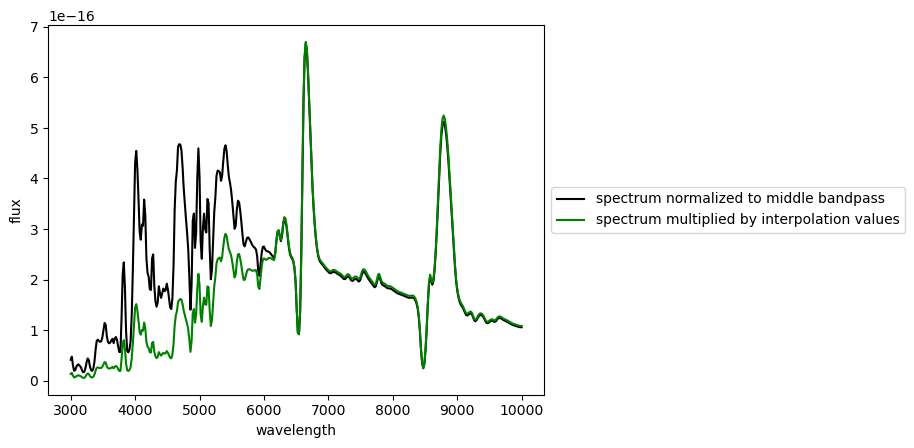

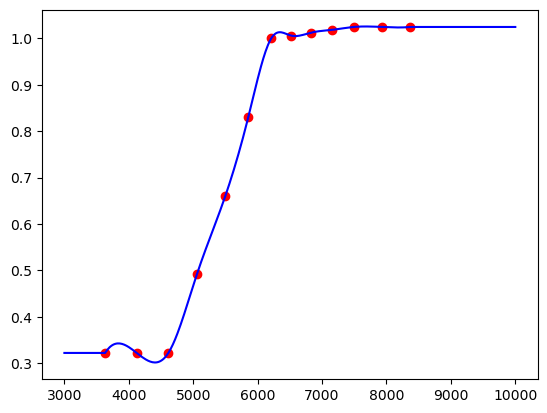

sdssg 19.004498480327978
sdssr 17.521828203186818
sdssi 17.445630947752317


In [32]:
spectrum1 = mangle_1sttime(new_flux, template_mags)

In [33]:
test = pd.read_csv('/global/homes/a/alexisa/sn_sarafina/sn/fe/sn04a.p50.dat', delimiter= ' ', header=None)

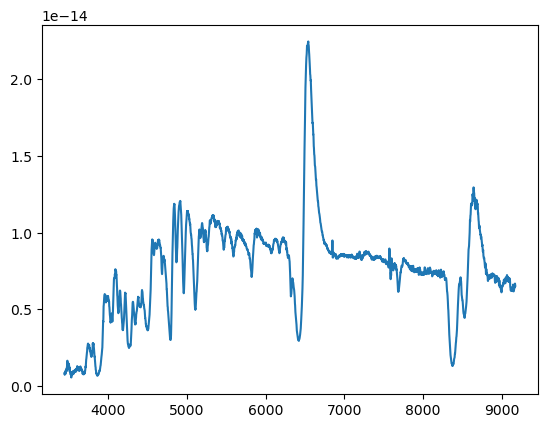

In [34]:
plt.plot(test[0],test[1])

In [30]:
# a table that contains the observed mags and the template mags
mags_table.loc[1] = template_mags

print('0 = observed mags, 1 = template (model) mags')
print(mags_table)

0 = observed mags, 1 = template (model) mags
       sdssg      sdssr      sdssi
0  18.084479  17.469188  17.427512
1  16.854801  17.469200  17.454016


In [4]:
sn = tarfile.open("sn.tar", "r")

In [5]:
sn.getmembers()

[<TarInfo 'sn' at 0x7fa9ae799a80>,
 <TarInfo 'sn/hbeta' at 0x7fa9ae799900>,
 <TarInfo 'sn/hbeta/s04du.p30.dat' at 0x7fa9ae799c00>,
 <TarInfo 'sn/hbeta/sn69l.p34.dat' at 0x7fa9ae7999c0>,
 <TarInfo 'sn/hbeta/s04dr.p40.dat' at 0x7fa9ae799840>,
 <TarInfo 'sn/hbeta/sn04t.p15.dat' at 0x7fa9ae799cc0>,
 <TarInfo 'sn/hbeta/s04eb.p15.dat' at 0x7fa9ae799d80>,
 <TarInfo 'sn/hbeta/s04et.p10.dat' at 0x7fa9ae799f00>,
 <TarInfo 'sn/hbeta/sn93w.p26.dat' at 0x7fa9ae799b40>,
 <TarInfo 'sn/hbeta/sn93w.p09.dat' at 0x7fa9ae799e40>,
 <TarInfo 'sn/hbeta/squst.p60.dat' at 0x7fa9ae799fc0>,
 <TarInfo 'sn/hbeta/s99em.p15.dat' at 0x7fa9ae79a080>,
 <TarInfo 'sn/fe' at 0x7fa9ae79a140>,
 <TarInfo 'sn/fe/s04em.p35.dat' at 0x7fa9ae79a200>,
 <TarInfo 'sn/fe/s99em.p61.dat' at 0x7fa9ae79a2c0>,
 <TarInfo 'sn/fe/sn69l.p61.dat' at 0x7fa9ae79a380>,
 <TarInfo 'sn/fe/sn04a.p50.dat' at 0x7fa9ae79a440>,
 <TarInfo 'sn/fe/s99em.p35.dat' at 0x7fa9ae79a5c0>,
 <TarInfo 'sn/fe/sn88a.p49.dat' at 0x7fa9ae79a680>,
 <TarInfo 'sn/fe/sn93w.p

In [9]:
sn.extract(member="sn/fe/s04em.p35.dat", path="/global/homes/a/alexisa/sn_sarafina")

In [12]:
sn.extractall( path= "/global/homes/a/alexisa/sn_sarafina")

In [37]:
print(test)
#print(test.columns)
test
print(test.shape[0])
print(test[0][test.shape[0]-1])

               0         1
0      3265.3061  0.093344
1      3267.2732 -0.026305
2      3269.2402  0.122344
3      3271.2073  0.124444
4      3273.1743  0.046061
...          ...       ...
3686  10515.8590  0.205652
3687  10517.8260  0.167234
3688  10519.7930  0.069681
3689  10521.7610  0.059659
3690  10523.7280  0.130501

[3691 rows x 2 columns]
3691
10523.728


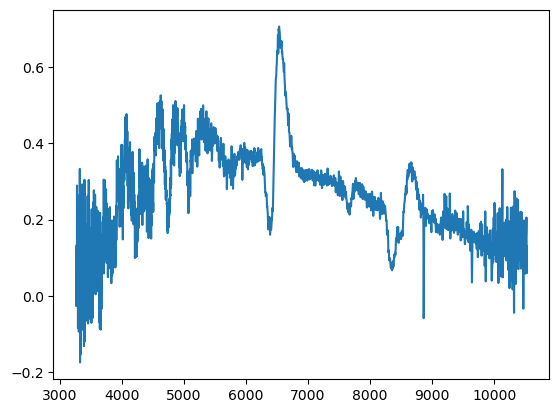

In [23]:
plt.plot(test[0],test[1])

In [38]:
#create model spectrum at same redshift as observed SN
wave = np.linspace(test[0][0], test[0][test.shape[0]-1], test.shape[0]) # match size of flux array if reading in csv

# get type IIP template from sncosmo
model = sncosmo.Model(source='nugent-sn2p')
model.set(z=0.01815) # set template redshift to redshift of the observed SN

# get flux at day 50
flux = model.flux([50], wave)[0]
fluxerr= flux*0.01 # arbitrary uncertainty 

spectrum = sncosmo.Spectrum(wave, flux, fluxerr, time=50) #creates spectrum with the flux and wavelength we observed 

In [39]:
model.param_names

['z', 't0', 'amplitude']